In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import csv
import math
import itertools
import matplotlib.pyplot as plt
import numpy as np

# Functions declaration

## Data loading and graph generation

In [16]:
# Read researchers from CSV
def read_researchers(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        return [row[0] for row in reader]
    
# Read co-authors from CSV
def read_coauthors(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        return [tuple(row) for row in reader]
    
# Read current collaborators from CSV
def read_current_collaborators(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        return [tuple(row) for row in reader]
    
# Create the network
def create_network(researchers, coauthors, current_collaborators = None ):
    if current_collaborators is None:
        current_collaborators = []

    G = nx.Graph()
    # Add nodes for reseachers
    G.add_nodes_from(researchers)

    # Add edges for co-authorship
    for pair in coauthors:
        researcher1, researcher2 = pair
        if G.has_edge(researcher1, researcher2):
            # Increment the 'weight' attribute if the edge already exists
            G[researcher1][researcher2]['weight'] += 1
        else:
            # Add a new edge with 'weight' attribute set to 1
            G.add_edge(researcher1, researcher2, weight=1)

    # Add dashed edges for potential future collaborations
    for collaboration in current_collaborators:
        researcher1, researcher2 = collaboration
        # Check if the professors are already connected by a co-authorship edge
        if not G.has_edge(researcher1, researcher2):
            G.add_edge(researcher1, researcher2, weight=1, style='dashed')

    G.add_edges_from(current_collaborators)
    return G

# Network ploting
def draw_network_plot(G):
    # Draw the graph
    pos = nx.circular_layout(G)  # Circular layout
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    styles = [G[u][v].get('style', '-') for u, v in edges]
    colors = ['grey' if style == 'dashed' else '#FC5153' for style in styles]

    nx.draw(G, pos, with_labels=False, node_color='#002145', node_size=1500, font_size=10, font_weight='bold', width=weights, style=styles, edge_color=colors)

    # Calculate angle for each node
    center = [0.0, 0.0]
    node_angles = {node: math.atan2(pos[node][1] - center[1], pos[node][0] - center[0]) for node in G.nodes()}

    # Draw node labels radially outside the perimeter
    radius = 1.43
    node_labels = {node: (center[0] + radius * math.cos(angle), center[1] + radius * math.sin(angle)) for node, angle in node_angles.items()}

    nx.draw_networkx_labels(G, node_labels, font_size=10, font_weight='bold',  font_color='#363636')

    # Show the plot
    # plt.title('Our Academic Network')
    x_max = max(list(node_labels.values()))[0]
    x_min = min(list(node_labels.values()))[0]
    x_margin = (x_max - x_min) * 0.20

    plt.xlim(x_min - x_margin, x_max + x_margin)
    plt.ylim(x_min - x_margin, x_max + x_margin)

    # Save the plot
    plt.savefig('network_plot.png')

## Graph analysis

### Contents: 

Degree Distribution: the distribution of degrees (number of connections) can provide insights into the connectivity of the network. In an academic network, we are looking at the number of collaborations each professor has.

Centrality Measures: Centrality measures identify the most important nodes in the network. We use here the following measures of centrality:

* Degree Centrality: the number of connections each node has.
* Betweenness Centrality: the number of shortest paths that pass through a node, indicating its importance as a bridge between different parts of the network.
* Closeness Centrality: Measures how close a node is to all other nodes in the network, indicating its ability to quickly communicate or spread information.
* Clustering Coefficient: the degree to which nodes tend to cluster together. In our research network, this indicates the presence of tightly-knit research groups.

Path Length Distribution: the distribution of shortest path lengths between nodes provides insights into the overall structure and connectivity of the network.

Network Robustness: assesses how the network responds to node or edge removal, providing insights into its resilience.

In [33]:
# Analyze the network
def analyze_network(G):
    degree_distribution = [len(list(G.neighbors(node))) for node in G.nodes()]
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    clustering_coefficient = nx.average_clustering(G)
    
   # Compute path lengths for unique pairs of nodes
    path_lengths = []
    for source, target in itertools.combinations(G.nodes(), 2):
        try:
            path_length = nx.shortest_path_length(G, source=source, target=target)
            path_lengths.append(path_length)
        except nx.NetworkXNoPath:
            # If no path exists between the nodes, continue to the next pair
            continue

    network_robustness = nx.node_connectivity(G)


    return degree_distribution, degree_centrality, betweenness_centrality, closeness_centrality, clustering_coefficient, path_lengths, network_robustness

# Generate a report
def generate_report(degree_distribution, degree_centrality, betweenness_centrality, closeness_centrality, clustering_coefficient, path_lengths, network_robustness, title = "Network Analysis Report:"):
    report = title+"\n\n"
    report += "Degree Distribution: {}\n".format(degree_distribution)
    report += "Degree Centrality: {}\n".format(degree_centrality)
    report += "Betweenness Centrality: {}\n".format(betweenness_centrality)
    report += "Closeness Centrality: {}\n".format(closeness_centrality)
    report += "Clustering Coefficient: {}\n".format(clustering_coefficient)
    report += "Path Length Distribution: {}\n".format(path_lengths)
    report += "Network Robustness: {}\n".format(network_robustness)

    # Save report to text file
    with open(title+'.txt', 'w') as f:
        f.write(report)    

    return report


# Generate plot of report
def generate_report_png(degree_distribution, degree_centrality, betweenness_centrality, closeness_centrality, clustering_coefficient, path_lengths, network_robustness,plot_color = "#002145", title = 'Academic Network Analysis Report'):
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))

    # Define the color
    bar_color = plot_color

 # Plot degree distribution for each professor
    professors = list(range(len(degree_distribution)))
    degrees = degree_distribution
    axs[0, 0].bar(researchers, degrees, color=bar_color, alpha=0.9)
    axs[0, 0].set_xlabel('Professor')
    axs[0, 0].set_ylabel('Degree')
    axs[0, 0].set_title('Degree Distribution')

    # Plot degree centrality
    axs[0, 1].bar(degree_centrality.keys(), degree_centrality.values(), color=bar_color, alpha=0.9)
    axs[0, 1].set_xlabel('Node')
    axs[0, 1].set_ylabel('Degree Centrality')
    axs[0, 1].set_title('Degree Centrality')

    # Plot betweenness centrality
    axs[1, 0].bar(betweenness_centrality.keys(), betweenness_centrality.values(), color=bar_color, alpha=0.9)
    axs[1, 0].set_xlabel('Node')
    axs[1, 0].set_ylabel('Betweenness Centrality')
    axs[1, 0].set_title('Betweenness Centrality')

    # Plot closeness centrality
    axs[1, 1].bar(closeness_centrality.keys(), closeness_centrality.values(), color=bar_color, alpha=0.9)
    axs[1, 1].set_xlabel('Node')
    axs[1, 1].set_ylabel('Closeness Centrality')
    axs[1, 1].set_title('Closeness Centrality')

    # Plot clustering coefficient
    axs[2, 0].bar(['Clustering Coefficient'], [clustering_coefficient], color=bar_color, alpha=0.9)
    axs[2, 0].set_ylabel('Clustering Coefficient')
    axs[2, 0].set_title('Clustering Coefficient')

    # Plot network robustness
    axs[2, 1].bar(['Network Robustness'], [network_robustness], color=bar_color, alpha=0.9)
    axs[2, 1].set_ylabel('Network Robustness')
    axs[2, 1].set_title('Network Robustness')

    # Add title to the figure
    fig.suptitle(title, fontsize=16)


    # Adjust layout
    plt.tight_layout()

# Save the figure as PNG
    plt.savefig(title+'.png', bbox_inches='tight')
    plt.close()

In [24]:
# csv data
researchers_file = "researchers.csv" 
coauthors_file = "coauthors.csv"
current_collaborators_file = 'current_collaborators.csv'

# Read data from CSV files
researchers = read_researchers(researchers_file)
coauthors = read_coauthors(coauthors_file)
current_collaborators = read_current_collaborators(current_collaborators_file)


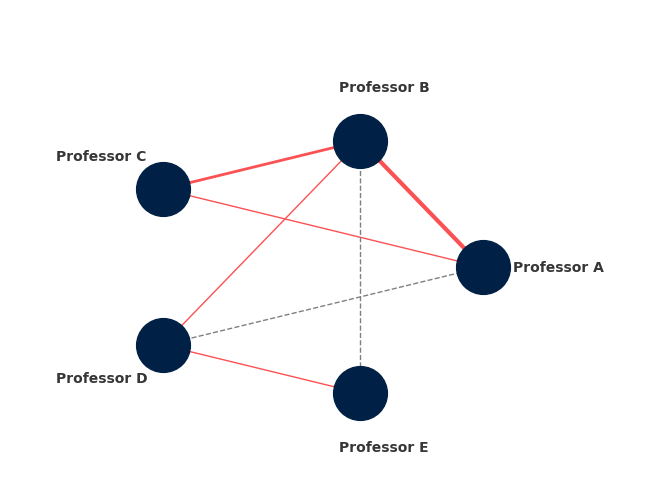

In [36]:
# Create the network
G_current = create_network(researchers, coauthors)
G_target = create_network(researchers, coauthors, current_collaborators)

draw_network_plot(G_target)

In [37]:
 # Analyze the network
c_degree_distribution, c_degree_centrality, c_betweenness_centrality, c_closeness_centrality, c_clustering_coefficient, c_path_lengths, c_network_robustness = analyze_network(G_current)
t_degree_distribution, t_degree_centrality, t_betweenness_centrality, t_closeness_centrality, t_clustering_coefficient, t_path_lengths, t_network_robustness = analyze_network(G_target)

# Generate report files
generate_report(c_degree_distribution, c_degree_centrality, c_betweenness_centrality, c_closeness_centrality, c_clustering_coefficient, c_path_lengths, c_network_robustness,'Academic Network Current State')
generate_report(t_degree_distribution, t_degree_centrality, t_betweenness_centrality, t_closeness_centrality, t_clustering_coefficient, t_path_lengths, t_network_robustness,'Academic Network Target State')

# Generate report plot as PNG
generate_report_png(c_degree_distribution, c_degree_centrality, c_betweenness_centrality, c_closeness_centrality, c_clustering_coefficient, c_path_lengths, c_network_robustness, "#002145",'Academic Network Current State')
generate_report_png(t_degree_distribution, t_degree_centrality, t_betweenness_centrality, t_closeness_centrality, t_clustering_coefficient, t_path_lengths, t_network_robustness, "#b22029",'Academic Network Target State')